# Preliminary of hack-phenomx env and inital development tasks
* To be used with lal env configured with phenomxdebug
* The goal of this notebook is to verify implementation of eff rd freqs for HMs by plotting and readout of depug prints

In [2]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup the notebook's environment
import lalsimulation as lalsim
import lal
import numpy as np
from numpy import *
from matplotlib.pyplot import *
from positive import *
from nrutils import lalphenom
from positive.units import *
from nrutils import scsearch,gwylm
from xcp import *
import warnings

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from XCP.
(xcp.core)>> Catalog of calibration runs stored to "xcp.calibration_catalog"
(xcp.core)>> Metadata dictionary for calibration runs stored to "xcp.metadata_dict"
(xcp.core)>> Metadata dictionary for Ed's catalog paper stored to "xcp.catalog_paper_metadata"


In [3]:
# Let the user know where lalsimulation lives

#
lalsim_path = lalsim.__path__[0]
lalsuite_repo_path = lalsim_path.split('lib')[0]+'src/lalsuite/'
branch_name = bash('cd %s && git status'%lalsuite_repo_path).decode("utf-8").split('On branch ')[-1].split('\n')[0]

#
alert('We are getting our LALSimulation from:\n%s\n'%magenta(lalsim_path))
alert('We think that the related lalsuite source files are here:\n%s\n'%green(lalsuite_repo_path))
alert('Lastly, we are currently on this branch: %s\n'%bold(magenta(branch_name)))

#
if branch_name != 'pnrv1-ll':
    alert('We are not on the expected branch. This may cause unexpected behavior.',say=True)

(notebook)>> We are getting our LALSimulation from:
/Users/book/opt/anaconda2/envs/hack-phenomx3/lib/python3.6/site-packages/lalsimulation

(notebook)>> We think that the related lalsuite source files are here:
/Users/book/opt/anaconda2/envs/hack-phenomx3/src/lalsuite/

(notebook)>> Lastly, we are currently on this branch: pnrv1-ll



## Load reference NR data

In [4]:
# Find a catalog entry of interest using a keyword search
# a = scsearch(keyword='q1a02t120',verbose=True)[0]
# a = scsearch(keyword='q1a02t90_T_96_384',verbose=True)[0]
a = scsearch(keyword='q8a08t150dP2_T_120_480',verbose=True)[0]

(scsearch)>> Found keyword (=q8a08t150dP2_T_120_480) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
(scsearch)>> ## Found 2 possibly degenerate simulations:
(scsearch)>> [0001][pnr-catalog] q8: 1chi0.80-p-q8.00	(q8a08t150dP2_T_120_480)
(scsearch)>> [0002][hogshead] q8precessing: 1chi0.80-p-q8.00	(q8a08t150dP2_T_120_480)



In [7]:
# Load the realted NR waveform
y = {}
y['raw'] = gwylm(a,lmax=3,dt=0.5,clean=not True,verbose=False,pad=2000,load_dynamics=False)

(romline!)>> N is 2, but it must be less than or equal to 3. We have set N=3. This course is often desired in cases where N=2 is naively given.
(__calc_radiated_linear_momentum__!)>> The current objects max ell value is 3, but we recommend a value of at least 4 for accurate determination of radiated linear momentum.


In [8]:
# Generate waveform in L-frame (this rotates all multipoles and vector metadata)
# y['j'] = y['raw'].__calc_j_of_t_frame__()
y['j'] = y['raw'].__calc_initial_j_frame__()

(__rotate_frame_at_all_times__)>> TIME DOMAIN rotation specified
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.


In [9]:
# Generate waveform in L-frame (this rotates all multipoles and vector metadata)
y['lal'] = y['j'].__calc_initial_l_frame__()

(__rotate_frame_at_all_times__)>> TIME DOMAIN rotation specified
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated. This includes radiated and remnant quantities.


## Compute model waveform for comparison

In [10]:

def PolarizationsFD(approximant, modeList, m1, m2, s1, s2, delta_f, phiRef,nu0 = 0,pflag=501, ReturnCoPrec=1):
      
    lalparams = lal.CreateDict()
    
    #
    output_modes = {}
    
    #
    ModeArray = lalsim.SimInspiralCreateModeArray()
    for mode in modeList:
        
        #
        l,m = mode
        
        #
        lalsim.SimInspiralModeArrayActivateMode(ModeArray, l,m)
        lalsim.SimInspiralWaveformParamsInsertModeArray(lalparams, ModeArray)

        #
        lalsim.SimInspiralWaveformParamsInsertPhenomXHMThresholdMband(lalparams, 0)
        lalsim.SimInspiralWaveformParamsInsertPhenomXPHMThresholdMband(lalparams, 0)

        #
        lalsim.SimInspiralWaveformParamsInsertPhenomXReturnCoPrec(lalparams, ReturnCoPrec)
        
        #
        if pflag:
            lalsim.SimInspiralWaveformParamsInsertPhenomXPrecVersion( lalparams, pflag )

        #
        f_min       = 10.0
        f_max       = 2048.0
        Omega       = 0.
        inclination = 0 # Chosen so that it doesn't correxpond to a spherical hamonic root
        distance_Mpc= 100.0
        distance    = distance_Mpc*1.0e6*lal.PC_SI

        Hp, Hc = lalsim.SimInspiralChooseFDWaveform(m1=lal.MSUN_SI*m1,
                                                m2=lal.MSUN_SI*m2, 
                                                S1x=s1[0], S1y=s1[1], S1z=s1[2],
                                                S2x=s2[0], S2y=s2[1], S2z=s2[2],
                                                distance=distance, 
                                                inclination=inclination, 
                                                LALpars=lalparams,
                                                phiRef=phiRef, 
                                                f_ref=f_min,
                                                deltaF=delta_f,
                                                f_min=f_min,
                                                f_max=f_max,
                                                longAscNodes=Omega,
                                                eccentricity=0.0,
                                                meanPerAno=0.0,
                                                approximant=approximant) 

        #
        freqs = np.arange(len(Hp.data.data)) * delta_f
        hp = Hp.data.data
        hc = Hc.data.data
        
        if not ( approximant in (lalsim.IMRPhenomXP,lalsim.IMRPhenomXPHM) ):

            #
            s = -2
            spherical_harmonic = sYlm(s,l,m,inclination,phiRef)
            hp /= spherical_harmonic
            hc /= spherical_harmonic
        
        #
        Mtot = m1+m2
        hp = codehf(hp,Mtot,distance_Mpc)
        hc = codehf(hc,Mtot,distance_Mpc)
        f  = codef(freqs,Mtot) 
        
        #
        output_modes[l,m] = (hp,hc,f)
    
    #
    return output_modes

In [14]:

l,m = 3,3
modeList = [ [l,m] ]
pflag = 500
M = 100

# m1 = y['lal'].m1 * M / ( y['lal'].m1 + y['lal'].m2 )
# m2 = y['lal'].m2 * M / ( y['lal'].m1 + y['lal'].m2 )
# s1 = [0,0,y['lal'].X1[-1]] # Only use z-component becuase PhenomXHM (no precession) is the approx
# s2 = [0,0,y['lal'].X2[-1]] # Only use z-component becuase PhenomXHM (no precession) is the approx

m1 = a.m1 * M / ( a.m1 + a.m2 )
m2 = a.m2 * M / ( a.m1 + a.m2 )
nonprec_s1 = [0,0,y['lal'].X1[-1]] # Only use z-component becuase PhenomXHM (no precession) is the approx
nonprec_s2 = [0,0,y['lal'].X2[-1]] # Only use z-component becuase PhenomXHM (no precession) is the approx
s1 = y['lal'].X1 #
s2 = y['lal'].X2 # 

delta_f = 0.125
phiRef = 0

#
h     = {}
ls    = {}
lw    = {}
alpha = {}


#
key = 'XAS'
moments_dict_a = PolarizationsFD(lalsim.IMRPhenomXAS, modeList, m1, m2, nonprec_s1, nonprec_s2, delta_f, phiRef, pflag=0, ReturnCoPrec=1)
hp,hc,f    = moments_dict_a[l,m]
h[key]     = hp + 1j*hc
ls[key]    = '-'
lw[key]    = 1
alpha[key] = 0.3

# #
# key = 'XP-CP-Sz-Only'
# moments_dict_b = PolarizationsFD(lalsim.IMRPhenomXP, modeList, m1, m2, nonprec_s1, nonprec_s2, delta_f, phiRef, pflag=0, ReturnCoPrec=1)
# hp,hc,f    = moments_dict_b[l,m]
# h[key]     = hp + 1j*hc
# ls[key]    = ':'
# lw[key]    = 4
# alpha[key] = 1

#
key = 'XP-CP'
moments_dict_1 = PolarizationsFD(lalsim.IMRPhenomXP, modeList, m1, m2, s1, s2, delta_f, phiRef, pflag=0, ReturnCoPrec=1)
hp,hc,f    = moments_dict_1[l,m]
h[key]     = hp + 1j*hc
ls[key]    = '-'
lw[key]    = 1
alpha[key] = 1

# #
# key = 'XP-CP-501'
# moments_dict_1 = PolarizationsFD(lalsim.IMRPhenomXP, modeList, m1, m2, s1, s2, delta_f, phiRef, pflag=501, ReturnCoPrec=1)
# hp,hc,f    = moments_dict_1[l,m]
# h[key]     = hp + 1j*hc
# ls[key]    = '-'
# lw[key]    = 1
# alpha[key] = 1

#
key = 'XP-CP-500'
moments_dict_1 = PolarizationsFD(lalsim.IMRPhenomXP, modeList, m1, m2, s1, s2, delta_f, phiRef, pflag=500, ReturnCoPrec=1)
hp,hc,f    = moments_dict_1[l,m]
h[key]     = hp + 1j*hc
ls[key]    = '-'
lw[key]    = 1
alpha[key] = 1

# #
# key = 'XP-CP-502'
# moments_dict_2 = PolarizationsFD(lalsim.IMRPhenomXP, modeList, m1, m2, s1, s2, delta_f, phiRef, pflag=502, ReturnCoPrec=1)
# hp,hc,f    = moments_dict_2[l,m]
# h[key]     = hp + 1j*hc
# ls[key]    = '-'
# lw[key]    = 1
# alpha[key] = 1

Text(0.5, 1.0, 'q8a08t150dP2_T_120_480')

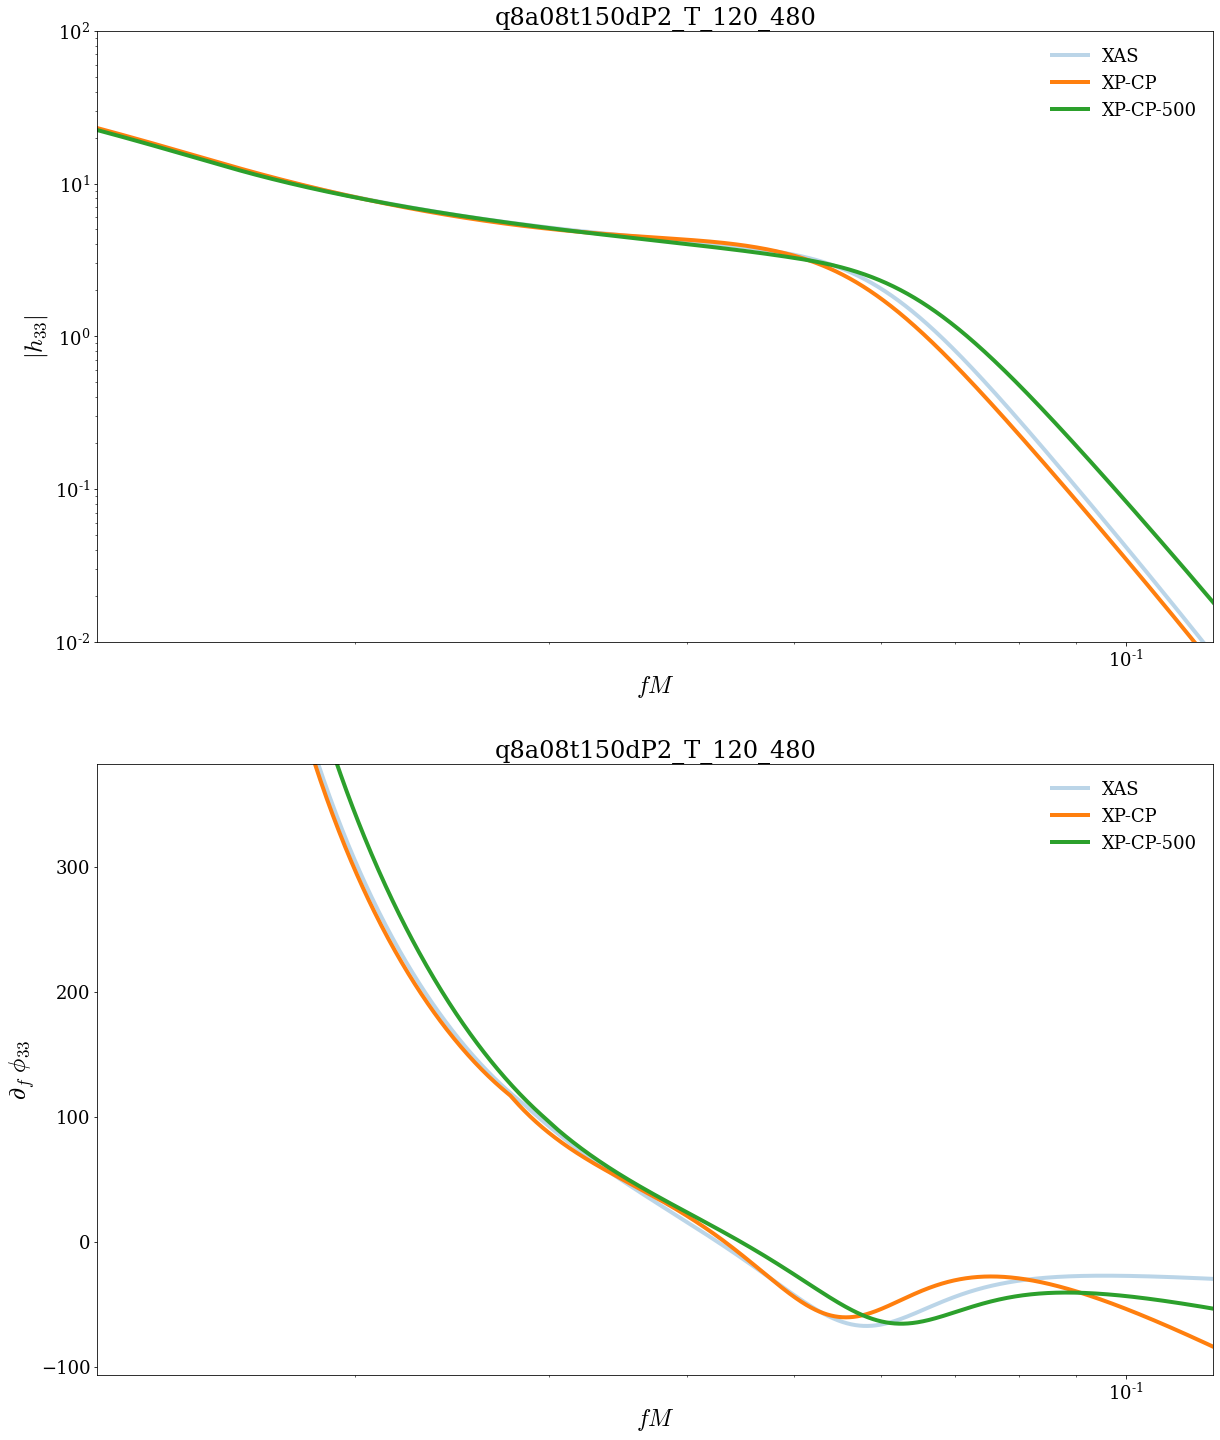

In [19]:
# Compare single mode generated above to NR

#
figure( figsize=5*figaspect(0.618*2) )


# --- #
a1=subplot(2,1,1)
# --- #


# plot( y['lal'].f,y['cp'][l,m]['strain'].fd_amp,label='nr-cp-frame',lw=lw,ls='--' )
# plot( y['lal'].f,y['cp-sym'][l,m]['strain'].fd_amp,label='nr-cp-sym-frame',lw=6,ls='-',color='k',alpha=0.2 )
# plot( y['lal'].f,y['lal'][l,m]['strain'].fd_amp,label='nr-lal-frame',lw=lw )

#
for key in h:
    plot( f, mean(abs(h['XP-CP'])) * abs(h[key])/mean(abs(h[key])),label=key,lw=4,ls=ls[key],alpha=alpha[key] )
    
# plot( f, abs(h1),label='PhenomXP-with-wRDEff',lw=lw, color='r' )
# plot( f, abs(h2),label='PhenomXP-With-SxSySz',lw=lw )
# plot( f, abs(ha),label='PhenomXAS',lw=1, color='k', alpha=0.16, ls='-' )
# plot( f, abs(hb),label='PhenomXP-With-Sz',lw=4, color='r', alpha=0.36, ls=':' )

xscale('log')
yscale('log')
xlim(1.5*y['lal'].wstart/(2*3.141592659),0.12)

mask = (y['lal'].f>min(xlim())) & (y['lal'].f<max(xlim()))
# ylim( lim(y['lal'][l,m]['strain'].fd_amp[mask], dilate=1.1, dilate_with_multiply=True) )
ylim(1e-2,1e2)

legend()
xlabel('$f M$')
ylabel(r'$|h_{%i%i}|$'%(l,m))
title(y['lal'].simname)


# --- #
subplot(2,1,2,sharex=a1)
# --- #

#
f0,f1 = 0.02,0.1
def calc_dphi(f,h,use_smooth=False):
    phi = np.unwrap(np.angle(h))
    dphi = spline_diff(f,phi)
    dphi -= np.mean(dphi[ (f>f0) & (f<f1) ])
    return smooth(dphi,width=20).answer if use_smooth else dphi


# plot( y['lal'].f,calc_dphi(y['lal'].f,y['cp'][l,m]['strain'].fd_y,use_smooth=True),label='nr-cp-frame',lw=lw,ls='--' )
# plot( y['lal'].f,calc_dphi(y['lal'].f,y['cp-sym'][l,m]['strain'].fd_y,use_smooth=True),label='nr-cp-sym-frame',lw=6,ls='-',color='k',alpha=0.2 )
# plot( y['lal'].f,calc_dphi(y['lal'].f,y['lal'][l,m]['strain'].fd_y),label='nr-lal-frame',lw=lw )

#
for key in h:
    plot( f, calc_dphi(f,h[key]),label=key,lw=4,ls=ls[key],alpha=alpha[key] )
    
# pi = 3.14159265359
# plot( f, calc_dphi(f,h1),label='PhenomXP-with-wRDEff',lw=lw, color='r' )
# plot( f, calc_dphi(f,h2),label='PhenomXP-With-SxSySz',lw=lw )
# plot( f, calc_dphi(f,ha),label='PhenomXAS',lw=1, color='k', alpha=0.16, ls='-' )
# plot( f, calc_dphi(f,hb),label='PhenomXP-With-Sz',lw=4, color='r', alpha=0.36, ls=':' )

xscale('log')
mask = (f>f0) & (f<f1)
ylim( lim(calc_dphi(f,h[key])[mask],dilate=.1) )
legend()
xlabel('$f M$')
ylabel(r'$\partial_{f}\;{\phi_{%i%i}}$'%(l,m))
title(y['lal'].simname)


# --- #
# savefig('/Users/book/Desktop/0_preliminaries_check_%s.png'%y['lal'].simname)
# --- #
